In [1]:
import numpy as np
from scipy import optimize
from numba import vectorize, float32, float64
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use(['science','notebook'])

import sys
sys.path.insert(0, '../src/pydftlj/')
from dft3d import Gradient
from dft3d import dft3d as dft
from eos import LJEOS 

from pymatgen.core import Structure
from pymatgen.analysis import structure_matcher

# Author: Elvis do A. Soares
# Github: @elvissoares
# Date: 2023-03-01

In [2]:
kB = 1.380649e-23 # J/K
Rconst = 0.082057366080960 # Gas constant
NA = 6.022e23 # Avogadro number

## Solid CIF file Information

In [3]:
structure_name = 'MOF-5'
structure = Structure.from_file('../structures/'+structure_name+'.cif')
structure.make_supercell(2)
print('formula:  ', structure.formula)
print('num_sites:', structure.num_sites)

formula:   Zn256 H768 C1536 O832
num_sites: 3392


In [4]:
coordinates = structure.cart_coords.T
L = np.array([l/2 for l in structure.lattice.lengths])
print('Cell dimensions: ', L)
Vcell = L[0]*L[1]*L[2]
print('Cell volume: ', Vcell)

Cell dimensions:  [25.86584 25.86584 25.86584]
Cell volume:  17305.325019903623


# Force Field for solid-fluid interaction

In [5]:
forcefield_name = 'DREIDING'
forcefield = pd.read_csv('../parameters/'+forcefield_name+'-forcefield.dat',delim_whitespace=True)
forcefield

,atom,sigma/AA,epsilon/kB,mass/u
0,H,2.84642,7.64893,1.00784
1,C,3.47299,47.85620,12.01070
2,N,3.26256,38.94920,14.00670
3,O,3.03315,48.15810,15.99900
4,Cu,3.11000,2.51800,63.54600
5,Zn,4.04468,27.67710,65.38000


# Fluid Information

In [6]:
# PCSAFT: Gross, J., & Sadowski, G. (2001). Industrial & Engineering Chemistry Research, 40(4), 1244–1260.
# TraPPE: M.G. Martin, and J.I. Siepmann, J. Phys. Chem. B 102, 2569-2577 (1998).
# SoftSAFT: Blas, F. J., & Vega, L. F. (1998). Industrial and Engineering Chemistry Research, 5885(1996), 660–674.
fluid_molecule = 'CH4'
epsilon = {'TraPPE': 148.0, 'PCSAFT': 150.03, 'SoftSAFT': 147.302}
sigma = {'TraPPE': 3.73, 'PCSAFT': 3.704, 'SoftSAFT': 3.722}

fluid_forcefield = 'PCSAFT'
epsilonff = epsilon[fluid_forcefield] # kelvin
sigmaff = sigma[fluid_forcefield] # angstrom
mff = 16.043
# epsilonff = 10.22 # kelvin
# sigmaff = 2.58 # angstrom
# mff = 4.0026

# Create the DFT object

In [7]:
Ngrid = 64

In [8]:
DFT = dft(gridsize=np.array([Ngrid,Ngrid,Ngrid]),fmtmethod='WBI',ljmethod='MMFA')

In [9]:
DFT.Set_Geometry(L)

In [10]:
DFT.GetSystemInformation()

============== The DFT 3D for LJ fluids ==============
Methods:
FMT : WBI - antisymmetrized
Attractive : MMFA
The grid is [64 64 64]
--- Geometry properties ---
Lx = 25.86584  A
Ly = 25.86584  A
Lz = 25.86584  A
Vol = 17305.325019903623  A³


In [11]:
DFT.Set_FluidProperties(sigma=sigmaff,epsilon=epsilonff)

In [12]:
DFT.GetFluidInformation()

--- Fluid properties ---
epsilon/kB = 150.03  K
sigma = 3.704  A


## Defining the Temperature

In [13]:
kT = 300.0 # kelvin 

DFT.Set_Temperature(kT)

In [14]:
DFT.GetFluidTemperatureInformation()

Temperature = 300.0  K
Baker-Henderson diameter = 3.544  A


## Generating the External Potential

In [15]:
sigmasf = np.zeros(structure.num_sites)
epsilonsf = np.zeros(structure.num_sites)
mss = 0.0

# Lorentz-Berthelot combination rule
for i, site in enumerate(structure):
    sigmasf[i] = 0.5*(sigmaff+forcefield["sigma/AA"][forcefield["atom"]==site.species_string])
    epsilonsf[i] = np.sqrt(epsilonff*forcefield["epsilon/kB"][forcefield["atom"]==site.species_string])
    mss = mss + float(forcefield["mass/u"][forcefield["atom"]==site.species_string])
    
mss = mss/8

In [16]:
print('Unit cell mass: ', mss, ' u')

Unit cell mass:  6158.863039999983  u


In [17]:
rhocr = 1e27*mss/(Vcell*NA) #kg/m3 crystal MOF-5 density

In [18]:
print('Crystal Density: ',rhocr,' kg/m3')

Crystal Density:  590.9898672923852  kg/m3


In [19]:
@vectorize
def ljpotential(r,eps,sigma):
    return 4*eps*((sigma/r)**(12)-(sigma/r)**(6))

In [20]:
%%time

Vext = np.zeros_like(DFT.rho)

X,Y,Z = np.meshgrid(DFT.x,DFT.y,DFT.z,indexing ='ij')
for i, site in enumerate(structure):
    R = np.sqrt((X-structure.cart_coords[i,0]+L[0]/2)**2 + (Y-structure.cart_coords[i,1]+L[1]/2)**2 + (Z-structure.cart_coords[i,2]+L[2]/2)**2)
    Vext[:] += ljpotential(R,epsilonsf[i],sigmasf[i])

del X,Y,Z,R

# np.save('externalpotential-CH4-MOF5-DREIDING-T='+str(kT)+'K-'+str(dft.gridsize)+'.npy',Vext)
# Vext[:] = np.load('externalpotential-CH4-MOF5-DREIDING-T='+str(kT)+'K-'+str(dft.gridsize)+'.npy')

DFT.Set_External_Potential(Vext)

CPU times: user 19.1 s, sys: 29.8 ms, total: 19.1 s
Wall time: 19.1 s


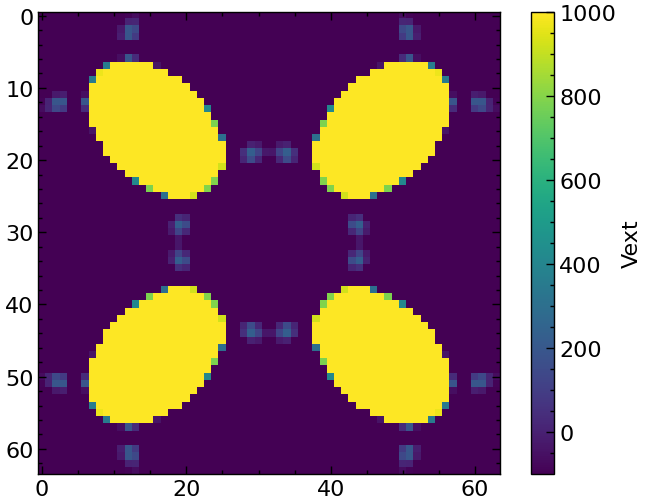

In [21]:
plt.imshow(DFT.Vext[:,:,26], cmap='viridis',vmin=-1e2,vmax=1e3)
plt.colorbar(label='Vext')
plt.show()

In [22]:
Vextpos = Vext.copy()
# Vextpos[Vextpos< 0.0] = 0.0

In [23]:
Vpore = np.sum(np.exp(-DFT.beta*Vextpos))*DFT.dV

In [24]:
Vpore

120470.53113489371

In [25]:
Vcell

17305.325019903623

In [26]:
# helium_void_fraction = Vpore/Vcell
helium_void_fraction = 0.852
# helium_void_fraction = 0.815

In [27]:
helium_void_fraction

0.852

In [28]:
Vpore = helium_void_fraction*Vcell

In [29]:
ljeos= LJEOS(sigma=sigmaff,epsilon=epsilonff,model='MBWR')

In [30]:
def rhofromBARpressure(pbar):
    def func(x,p):
        return ljeos.p(x,kT)-p,ljeos.dpdrho(x,kT), ljeos.d2pdrho2(x,kT)
    if np.isscalar(pbar):
        sol = optimize.root_scalar(func, x0=1e-2, fprime=True,fprime2=True,args=(1e-30*pbar/(1e-5*kB)), method='halley')
        rho = sol.root
    else:
        rho = np.empty_like(pbar)
        for i in range(pbar.size):
            sol = optimize.root_scalar(func, x0=1e-2, fprime=True,fprime2=True,args=(1e-30*pbar[i]/(1e-5*kB)), method='halley')
            rho[i] = sol.root
    return rho

In [31]:
pbararray = np.hstack((np.array([0.001,0.01,0.1,0.5,1.0,1.1,1.2,1.4,1.6,1.8]),np.arange(2.,61.,1.0)))

In [32]:
rhobarray = rhofromBARpressure(pbararray)

Text(0, 0.5, '$\\rho$ (molecules/$\\AA^{3}$)')

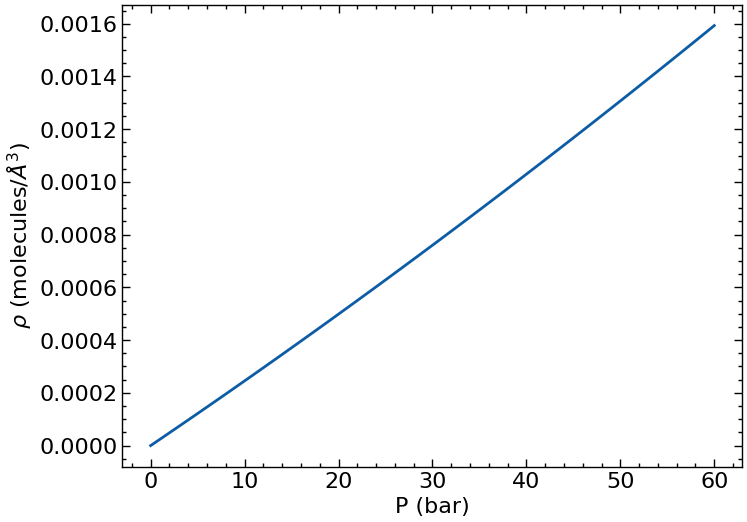

In [33]:
plt.plot(pbararray,rhobarray)
plt.xlabel(r'P (bar)')
plt.ylabel(r'$\rho$ (molecules/$\AA^{3}$)')

In [34]:
%%time

Nadsarray = np.zeros_like(rhobarray)

DFT.Set_BulkDensity(rhobarray[0])
DFT.Set_InitialCondition()

print('P (bar)\t rhob (AA^-3)\t Nabs(molecules/u.c.)')

for i in range(rhobarray.size):
    rhob = rhobarray[i]

    DFT.Set_BulkDensity(rhob)

    DFT.Calculate_Equilibrium(alpha0=0.25,rtol=1e-2,atol=1e-4,max_iter=20,method='picard',logoutput=False)
    DFT.Calculate_Equilibrium(alpha0=0.3,dt=1.0,rtol=1e-4,atol=1e-6,method='fire',logoutput=False)

    Nadsarray[i] = DFT.Nadstot
    print(pbararray[i],rhob,Nadsarray[i])

P (bar)	 rhob (AA^-3)	 Nabs(molecules/u.c.)
0.001 2.414327402592906e-08 0.00036762562815633864
0.01 2.414362477997023e-07 0.0010192537494670777
0.1 2.4147132506273807e-06 0.004027879477921867
0.5 1.2081363247647214e-05 0.017173717608683976
1.0 2.4182228404905662e-05 0.0611716051075396


/home/elvis/Google Drive/Projetos em Andamento/3-DFT 3D for H2 storage in MOF/codes/PyDFTlj/examples/../src/pydftlj/dft3d.py:229: RuntimeWarning: invalid value encountered in dphi3dnfuncWBI
  self.dphi3dn3 = dphi3dnfuncWBI(self.n3)
/home/elvis/Google Drive/Projetos em Andamento/3-DFT 3D for H2 storage in MOF/codes/PyDFTlj/examples/../src/pydftlj/dft3d.py:211: RuntimeWarning: divide by zero encountered in true_divide
  self.xi = np.sum(self.n2vec*self.n2vec,axis=0)/(self.n2**2)


1.2 2.9028038529957268e-05 3.263303988612571
1.4 3.387697249304177e-05 3.749099742995109
1.6 3.87290313079388e-05 4.366374455376668
1.8 4.358421599026345e-05 5.009156893476569
2.0 4.844252755743652e-05 5.638698240715879
3.0 7.278102439830642e-05 8.830260513204971
4.0 9.719784695759611e-05 11.96650346491078
5.0 0.00012169312425465689 15.174399953844118
6.0 0.0001462669861909136 18.41922597560793
7.0 0.00017091956343542343 21.695013878214077
8.0 0.00019565098730304676 24.991421914021476
9.0 0.00022046138962508808 28.283172836881143
10.0 0.0002453509026122626 31.55877910152198
11.0 0.00027031965870984636 34.75478992010911
12.0 0.00029536779044486846 37.89302508124256
13.0 0.00032049543026520184 40.94114246675059
14.0 0.0003457027103704136 43.86577138068115
15.0 0.00037098976253423493 46.66360432241014
16.0 0.0003963567179185094 49.370960436721816
17.0 0.000421803706878487 51.96841290960561
18.0 0.00044733085875932376 54.453300533662826
19.0 0.0004729383016836554 56.864747281793186
20.0 0.

In [35]:
Marray = mff*Nadsarray

In [36]:
Nexcarray = Nadsarray - rhobarray*Vpore
Mexcarray = Nexcarray*mff

In [64]:
df = pd.DataFrame()
df['Pressure (bar)'] = pbararray
df['Absolute adsorption (molecules/uc)'] = Nadsarray
df['Absolute adsorption (mg/g)'] = 1e3*Marray/mss
df['Absolute adsorption (%w.t.)'] = 100*Marray/(mss+Marray)
df['Absolute adsorption (mol/kg)'] = 1e3*Nadsarray/mss
df['Absolute adsorption (cm^3 STP/cm^3)'] = 1e30*(kB*273.15/101325)*Nadsarray/Vcell
df['Excess adsorption (molecules/uc)'] = Nexcarray
df['Excess adsorption (mg/g)'] = 1e3*Mexcarray/mss
df['Excess adsorption (%w.t.)'] = 100*Mexcarray/(mss+Marray)
df['Excess adsorption (mol/kg)'] = 1e3*Nexcarray/mss
df['Excess adsorption (cm^3 STP/cm^3)'] = 1e30*(kB*273.15/101325)*Nexcarray/Vcell

In [65]:
df.head()

,Pressure (bar),Absolute adsorption (molecules/uc),Absolute adsorption (mg/g),Absolute adsorption (%w.t.),Absolute adsorption (mol/kg),Absolute adsorption (cm^3 STP/cm^3),Excess adsorption (molecules/uc),Excess adsorption (mg/g),Excess adsorption (%w.t.),Excess adsorption (mol/kg),Excess adsorption (cm^3 STP/cm^3)
0,0.001,0.000368,0.000958,0.000096,0.000060,0.000791,0.000012,0.000030,0.000003,0.000002,0.000025
1,0.010,0.001019,0.002655,0.000266,0.000165,0.002192,-0.002541,-0.006618,-0.000662,-0.000412,-0.005464
2,0.100,0.004028,0.010492,0.001049,0.000654,0.008663,-0.031575,-0.082249,-0.008225,-0.005127,-0.067910
3,0.500,0.017174,0.044735,0.004473,0.002788,0.036936,-0.160956,-0.419267,-0.041925,-0.026134,-0.346174
4,1.000,0.061172,0.159344,0.015932,0.009932,0.131564,-0.295374,-0.769410,-0.076929,-0.047959,-0.635274


Text(0.5, 0, 'Pressure (bar)')

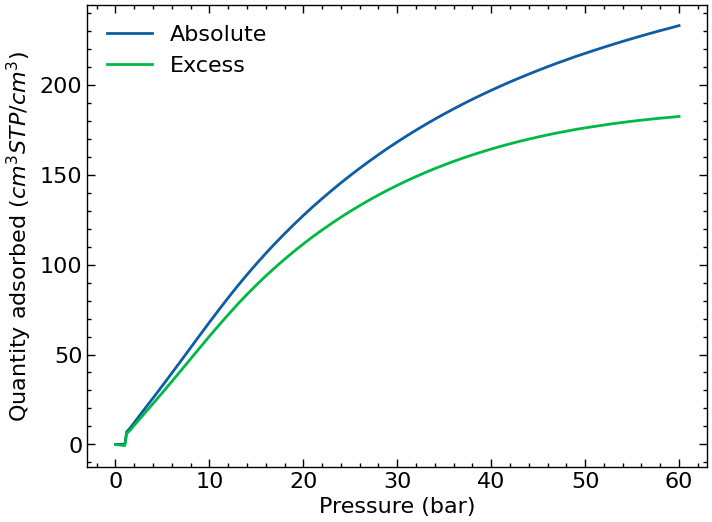

In [66]:
plt.plot(df['Pressure (bar)'],df['Absolute adsorption (cm^3 STP/cm^3)'],label='Absolute')
plt.plot(df['Pressure (bar)'],df['Excess adsorption (cm^3 STP/cm^3)'],label='Excess')
plt.legend(loc='best')
plt.ylabel('Quantity adsorbed $(cm^3 STP/cm^3)$')
plt.xlabel('Pressure (bar)')

In [81]:
pd.to_pickle(df,'dft-results-'+structure_name+'-'+fluid_molecule+'-'+fluid_forcefield+'-'+forcefield_name+'-T='+str(kT)+'K-N='+str(Ngrid)+'.pickle')
df.to_csv('dft-results-'+structure_name+'-'+fluid_molecule+'-'+fluid_forcefield+'-'+forcefield_name+'-T='+str(kT)+'K-N='+str(Ngrid)+'.dat', index=False,sep='\t')

In [83]:
# data = pd.read_csv('dft-results-'+structure_name+'-'+fluid_molecule+'-'+fluid_forcefield+'-'+forcefield_name+'-T='+str(kT)+'K-N='+str(Ngrid)+'.dat',sep='\t')

In [73]:
dft_data = pd.read_pickle('dft-results-'+structure_name+'-'+fluid_molecule+'-SoftSAFT-DREIDING-T='+str(kT)+'K-N=64.pickle')

# Plotting the results

In [86]:
exp_data = pd.read_excel('data/experimental/H2andCH4-MOFandZIF-isotherm-Zhou2007.xls',sheet_name='CH4-MOF5')
gcmc_data = pd.read_pickle('gcmc_isotherm.pickle')

(0.0, 60.0)

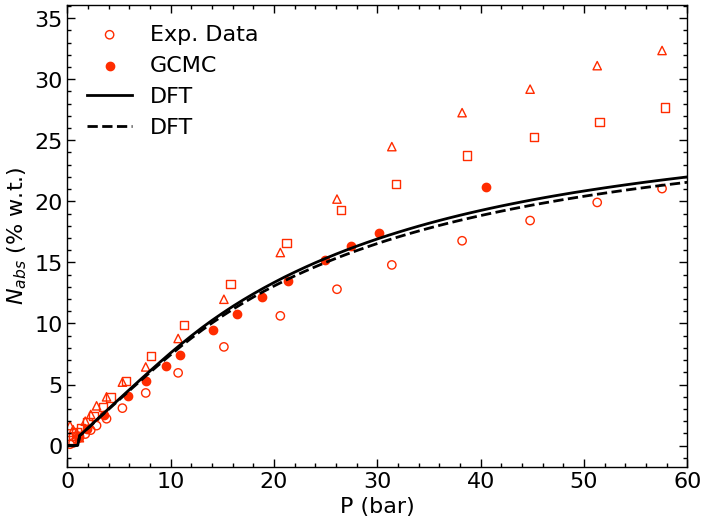

In [88]:
plt.scatter(exp_data['P(bar)-300K'],exp_data['Na(%wt)-300K'],marker='o',edgecolors='C3',facecolors='none',label='Exp. Data')
plt.scatter(exp_data['P(bar)-270K'],exp_data['Na(%wt)-270K'],marker='s',edgecolors='C3',facecolors='none')
plt.scatter(exp_data['P(bar)-300K'],exp_data['Na(%wt)-240K'],marker='^',edgecolors='C3',facecolors='none')

plt.scatter(gcmc_data['Pressure [bar]'],1e-3*100*gcmc_data['Absolute adsorption [mg/g]'],marker='o',color='C3',label='GCMC')

plt.plot(df['Pressure (bar)'],df['Absolute adsorption (%w.t.)'],'-',color='k',label='DFT')
plt.plot(dft_data['Pressure (bar)'],dft_data['Absolute adsorption (%w.t.)'],'--',color='k',label='DFT')
plt.legend(loc='best')
plt.xlabel('P (bar)')
plt.ylabel('$N_{abs}$ (% w.t.)')
plt.xlim(0,60)

In [76]:
exp_data = np.loadtxt('data/experimental/CH4-MOF5-.dat',skiprows=1)

(0.0, 60.0)

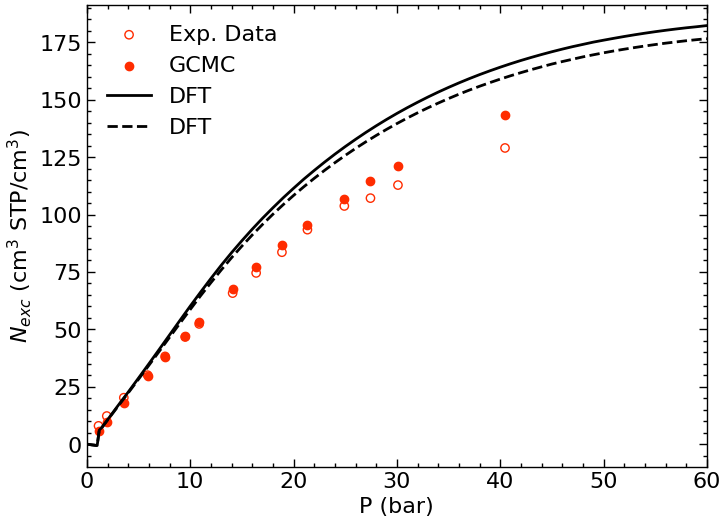

In [77]:
plt.scatter(1.01325*exp_data[:,0],exp_data[:,1],marker='o',edgecolors='C3',facecolors='none',label='Exp. Data')

plt.scatter(gcmc_data['Pressure [bar]'],gcmc_data['Excess adsorption [cm^3 STP/cm^3]'],marker='o',color='C3',label='GCMC')

plt.plot(df['Pressure (bar)'],df['Excess adsorption (cm^3 STP/cm^3)'],'-',color='k',label='DFT')
plt.plot(dft_data['Pressure (bar)'],dft_data['Excess adsorption (cm^3 STP/cm^3)'],'--',color='k',label='DFT')
plt.legend(loc='best')
plt.xlabel('P (bar)')
plt.ylabel('$N_{exc}$ (cm$^3$ STP/cm$^3$)')
plt.xlim(0,60)